> Kalman filters are a type of Bayesian filter (at least that is the lens we will use to analyze them). They solve a type of mathematical problem known as the filtering problem analytically by assuming we have a linear Gaussian state-space system. This means the relationships between our states and measurements are linear and the states and measurements are assumed to be Normally distributed. Despite these restrictive assumptions Kalman filters are widely used for applications such as object tracking (e.g. missiles, robots, vehicles etc.) and navigation. Even if that wasn't the case it is fascinating to explore the topic of filtering through the Kalman filter due to how (relatively) accessible it is. In this post I want to go over some of the theory behind the Kalman filter and how Bayesian filters can be used to train generative models. *Note, I assume in this post you know about VAEs or DVAEs, so if you don't, go read my previous posts on those topics or look them up online* 

# Objective of this Post 

I like generative models. I'm even strange in the sense the applications aren't what I like the most (as cool as some of them are), it's the underlying theory. This is a fun post for me because control theory and Kalman filtering is what got me into research to begin with. I love learning about these topics in particular, there is something about the theory I find satisfying and interesting. When learning about Variational Autoencoders (VAEs) and Dynamical Variational Autoencoders (DVAEs), the similarities between these models and Bayesian filtering started to become clearer the more I studied them. Finally, when I learned about using Importance Sampling to improve the objective function for training VAEs notably in the sequential case outlined by papers such as [@Naesseth2017] and [@Maddison2017], the connection became clear. I wanted to share some these connections in this post as it may clarify the theory behind generative models as it did for me. While the papers I cited use a Particle Filter framework I will use the Kalman filter as an example to make this easier to understand. 

Hence, in this post I will first go over some of the theory behind Kalman filtering and then talk about how they related to generative models. Let's get started. 

# Kalman Filtering
## Basic Concept

Imagine we have a tank of liquid, and we want to have an accurate reading of its temperature (perhaps we want to control this variable and keep it at a set value, but that isn't important here). "Okay, let's put a sensor that measures the temperature" you say. To which I would reply "good, but can we do better". Note that the sensors have noise or a certain tolerance, and so we may want to "filter" out this noise and have a tighter tolerance. How could we do this? The Kalman filters answer would be to say that we have more information than just the sensor readings. We have the physics of the system, more precisely we have a mathematical model that can describe how the temperature should change as we add or take away heat from the system. So we can calculate what the temperature should be using the mathematical model, and we have a sensor reading. The Kalman filter is a tool that takes both of these and finds a new distribution that describes an updated temperature distribution which accounts for both the mathematical model's estimated value and the sensor reading. In a way the Kalman filter is just a fancy way of taking a weighted average between the estimated probability distribution of our mathematical model and the estimated distribution of our sensor value at the current time. The example below shows two Gaussian distributions multiplied to find a new distribution which is essentially a weighted average of the two product Gaussian's. 

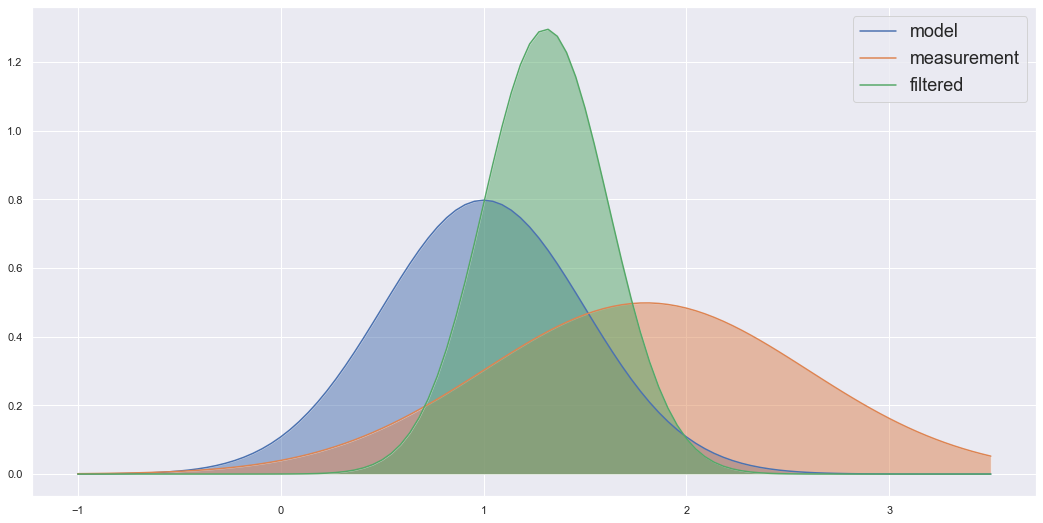

In [14]:
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sb 
sb.set_theme()
%matplotlib inline 

def gaussian_multiply(m1, s1, m2, s2):
    m = s2 / (s1 + s2) * m1 + s1 / (s1 + s2) * m2
    s = s1 * s2 / (s1 + s2)
    return m, s 

def gaussian(m, s, x):
    const = np.sqrt(2 * np.pi) * s 
    return 1 / const * np.exp(- (x - m)**2 / (2*s ** 2))

m1 = 1
s1 = 0.5
m2 = 1.8 
s2 = 0.8

x = np.linspace(-1,3.5,100)
m, s = gaussian_multiply(m1, s1, m2, s2)
y1 = gaussian(m1, s1, x)
y2 = gaussian(m2, s2, x)
y = gaussian(m, s, x)

plt.figure(figsize=(18,9))
plt.plot(x, y1, label="model")
plt.plot(x, y2, label="measurement")
plt.plot(x, y, label="filtered")
plt.fill_between(x, y1, alpha=0.5)
plt.fill_between(x, y2, alpha=0.5)
plt.fill_between(x, y, alpha=0.5)
plt.legend(prop={"size": 18})
plt.show()

A few things can be noticed here. One this betrays an important property that is vital to the Kalman filter working. The product of 2 Gaussian distributions is also a Gaussian distribution. Hence, as long as our variables are Normally distributed the Kalman Filtering algorithm will work as it only needs to worry about Gaussian distributions. This is also important because the Gaussian distribution is fully described by the mean and variance of the distribution. Hence, when we are updating to the resultant filtered distribution, we only need to worry about 2 variables, the mean and variance (covariance in the multivariate case). That's essentially what the Kalman filter is, a set of equations that describe how to propagate the mean and variance forward in time and another set of equations to update the state's mean and variance based on the mean and variance of the sensor reading (or any observation related to the state). The other important assumption is that these equations have to be linear. This is important for the same reason, if they were nonlinear equations, the distribution would no longer be Gaussian distributions and so the equations would no longer apply. 

Note that other Bayesian filters like the Kalman filter apply the same concept that I explained here. However, they may use non-Gaussian distributions or nonlinear dynamics and so the Kalman filter can no longer be used. Since the Kalman filter is a simple case I am using it in this post to illustrate certain concepts; however, these ideas can be extended to more general filters like the Particle filter. 

## Algorithm 

Given the following state space equations for the system, 

$$
x_t = F_t x_{t-1} + w_t, \ w_t \sim \mathcal{N}(0,Q_t)
$$
$$
y_t = H_t x_t + v_t, \ v_t \sim \mathcal{N}(0,R_t)
$$
where, $x_t$ is the state (temperature in our example), $y_t$ is the measurement or observation, $F_t$ describes the dynamics of the state, $H_t$ describes the measurement function that converts states to measurements (e.g. if the measurements are represented by voltages in an electronic sensor $H_t$ converts the state from temperature to voltage), $w_t$ is some random noise added to our mathematical model known as the process noise, $Q_t$ is the covariance of that process noise, $v_t$ is the measurement noise and $R_t$ is the covariance that describes that noise. 
 
The equations for the Kalman filter are as follows, 

1. First propagate the previous time mean and covariance to the current time using our state space model. Also convert those variables to the measurement domain so we can directly compare our estimates to the observations. If they have different units for example we couldn't fairly compare them, e.g. it would be like saying 1000mm is way bigger compared to 1m. 
$$
\hat{x}^-_{t} = F_t \hat{x}^+_{t-1}
$$
$$
P^-_t = F_t P^+_{t-1} F_t^T + Q_t 
$$
$$
\mu_t = H_t \hat{x}^-_t
$$
$$
S_t = H_t P_t^- H_t^T + R_k
$$
2. Now incorporate the measurement (take the weighted average)
$$
K_t = P^-_t H_t^T S_k^{-1}
$$
$$
\hat{x}^+_t = x^-_t + K_t(y_t - \mu_t)
$$
$$
P^+_t = (I - K_t H_t)P^-_t
$$

Here I have used the "hat" symbol to refer to the mean of the state i.e. $\hat{x}$ is the mean of the random variable $x_t$. Also note, $P_t$ is the covariance of the state, the $-$ superscript refers to a "prior" and $+$ is the updated "posterior" statistic e.g. this shows us that $P_t^-$ is the prior covariance before we accounted for the measurement update, and once we do that we get $P_t^+$. $\mu$ and $S$ are the mean and covariance of the state transfered to the measurement space.

# Bayesian Formulation 

Since we are updating the distribution based on observations, this leads to a nice Bayesian interpretation of the filter. Because of this we can call the Kalman filter a Bayesian filter and other filters that solve the same filtering problem can fit into this category (e.g. Particle filter). Let's first look at a general Bayesian formulation of a filter before we dive specifically into the Kalman filter. 

We can write the Bayesian formulation of a filter as, 

$$
p(x_t|y_{1:t}) = \frac{p(y_{1:t}|x_t)p(x_t)}{p(y_{1:t})}
$$

Notice we can split the sequence of observations from $y_{1:t}$ to $y_t$ and $y_{1:t-1}$ i.e.

$$
p(x_t|y_{1:t}) = \frac{p(y_t, y_{1:t-1}|x_t)p(x_t)}{p(y_t, y_{1:t-1})}
$$
$$
p(x_t|y_{1:t}) = \frac{p(y_t|x_t)p(y_{1:t-1}|x_t)p(x_t)}{p(y_t|y_{1:t-1})p(y_{1:t-1})}
$$
$$
p(x_t|y_{1:t}) = \frac{p(y_t|x_t)}{p(y_t|y_{1:t-1})}\frac{p(y_{1:t-1}|x_t)p(x_t)}{p(y_{1:t-1})}
$$
$$
p(x_t|y_{1:t}) = \frac{p(y_t|x_t)p(x_t|y_{1:t-1})}{p(y_t|y_{1:t-1})}
$$

Note that the denominator is essentially a normalization constant for the probability distribution $p(x_t|y_{1:t})$, and so we can find it by summing the numerator. In the continuous case it would be an integral not a sum, so we get, 
$$
p(x_t|y_{1:t}) = \frac{p(y_t|x_t)p(x_t|y_{1:t-1})}{\int p(y_t|x_t)p(x_t|y_{1:t-1}) dx_t}
$$
When I said we could find the normalizing constant by computing the integral $\int p(y_t|x_t)p(x_t|y_{1:t-1}) dx_t$ I lied. Well, kind of, in most cases it is really difficult to solve this integral although not in the Kalman filtering case which is why it is the topic of this post.

The distribution $p(y_{1:t})$ is known as the marginal likelihood. From our Bayesian Filtering formulation you can see we can compute the marginal likelihood recursively using,
$$
p(y_{1:t}) = \prod_{t=1}^T p(y_t|y_{1:t-1})
$$
Note, when $t=1$ and $p(y_1|y_{1:0})$ we will just take this to mean $p(y_1)$. We would want to compute the marginal likelihood because it is a good loss function, i.e. maximising this likelihood would maximise the likelihood our model captures the actual observations, which is what we want. However, it is difficult to caculate it because as I mentioned $p(y_t|y_{1:t-1}) = \int p(y_t|x_t)p(x_t|y_{1:t-1}) dx_t$ which is a difficult integral to find. Although for the Kalman filter finding $p(y_t|y_{1:t-1})$ isn't too difficult. Note that $\int p(y_t|x_t)p(x_t|y_{1:t-1}) dx_t$ involves two distributions,

* $p(x_t|y_{1:t-1}) = \int p(x_t|x_{t-1}, y_{1:t-1}) p(x_{t-1}| y_{1:t-1})dx_{t-1}$, which essentially states using the previous filtering distribution $p(x_{t-1}, y_{1:t-1})$ and uses the dynamics $p(x_t|x_{t-1}, y_{1:t-1})$ defined by our state space model $x^-_t = F_t x^+_{t-1} + w_t$ to propagate that state foward in time. 
* $p(y_t|x_t)$ simply converts our predicted state to the measurement/observation domain also defined by our state space model, $y_t = H_t x_t^- + v_t$.

Hence, for the Kalman filter these are all Gaussian distributions so we can find the mean and covariance of the propagated state using,
$$
\hat{x}_t^- = F_t \hat{x}_{t-1}^+
$$
$$
P_t^- = F_t P_{t-1}^+ F_t^T + Q_t
$$
Then convert to the measurement domain 
$$
\mu_t = H_t \hat{x}_t^-
$$
$$
S_t = H_t P_t^- H_t^T + R_t
$$
Now $p(y_t|y_{1:t-1}) = \mathcal{N}(\mu_t, S_t)$ and the likelihood can be calculated by plugging in our observation $y_t$ into the Gaussian distribution. The idea would be the same for other Bayesian filters but most don't have analytical solutions like the Kalman filter does. For example, the Particle filter could do this by propagating particles forward in time using the state dynamics and then using the measurement function. However, here the distribution would be representing by how ever many particles you choose to use and their weights. 

After this all you would need is some optimization routine to optimize the parameters of your model based on this loss function. For example, the dynamics matrix $F_t$ could have some unknown elements in it denoted as $\theta_t$ that we might want to find to specify a model for our particular application. One might even want to use backprogation through some deep learning library like PyTorch or Tensorflow. This brings me to the connections betweens Variational Autoencoders (VAEs) and Bayesian filters. 

Before I move on though, I should mention that if you are interested about some of the specifics on the Kalman filter and this Bayesian formulation of the Kalman filter (e.g. you might want how to actually derive the Kalman filtering equations using this general Bayes' filter formulation) then I recommend a book by [@Sarkka2013] (which I think is free as a pdf download) or check out [this "book"](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python) by Roger Labbe if you are a beginner to this. I say "book" because they are really a collection of jupyter notebooks to create a sort of interactive book where you can play around with the code. But both of these helped me learn about the Kalman filter. 

## VAEs and Bayesian Filtering 

With a VAE we use Bayes' theorem to learn a generative model that can generate samples from a data distribution $p(Y)$ (normally we use the variable $X$ but I didn't want to confuse it with the states from above so since I used $y_t$ for measurements we're sticking with that). We wanted to optimize the VAE by maximizing $p(Y)$, or more practically, by minimizing $-\text{log}p(Y)$. But we couldn't because when using Bayes' theorem we found,

$$
p(X|Y) = \frac{p(Y|X)p(X)}{p(Y)} = \frac{p(Y|X)p(X)}{\int p(Y|X)p(X)dX}
$$

So $p(Y) = \int p(Y|X)p(X)dX$ and this was an integral that was too difficult to solve ... Wait a minute, isn't this the marginal likelihood? Yes it is, and the Kalman filter (or a Bayesian filter like the Particle filter) can be used to find this likelihood. This is what those papers I mentioned in the beginning noticed and utilized. They used a Particle filtering approach as Kalman filters restrict you to a Linear Gaussian system (although [@Bezenac2020] uses a Kalman filter with normalizing flows to transform the Gaussian distribution), but the principle remains the same. Also note that instead of a VAE you would extend it to a DVAE (VAE but for sequential data) as Bayesian filters deal with sequential variables. I just used the VAE because the notation is simpler. 

In the previous section mentioned that an optimization routine could be used along with the marginal likelihood as a loss function to optimize the parameters of the model. I also said backprop could be that optimization routine. A filtering algorithm could therefore be used to train a deep learning model based on the criteria defined by the marginal likelihood. This is exactly what we want a generative model to do, maximize the probability the data we generate (let's call it $\hat{Y}$) comes from the data distribution $p(Y)$. With this sequential case and Bayesian filtering formulation this creates a cool way of seeing how we might learn probabilistic dynamic systems using deep learning. 

Even if you don't end up using a filtering algorithm to optimize your DVAE and instead use ELBO; I hope this post has shown you why you are secretly learning the state space dynamics of a system when training these models. A lot of the theory behind generative models went over my head when I was first learning about it. But this really helped me ground my understanding in a theory I was comfortable with and understood relatively well. I hope this post managed to help you in a similar way or at least shown you a different perspective on this topic.